# <center> Group Project Sub 03 - Modeling and Strategy Development </center>

## AUTHORS:
### David Kwasi Nyonyo Mensah-Gbekor ( mensah-gbekor@hotmail.com)
### Alexander Botica ( alexbotica@yahoo.com)
### David Wonder Doe-Dekpey (wonderdoe85@yahoo.com)
### Alexander Victor Okhuese ( alexandervictor16@yahoo.com)

# TASKS

## 1. Modeling
    - Decide on an algorithm or group of algorithms (for example, ensemble techniques).
    - Fit the model.
    - Show that it works out of sample, and use appropriate cross-validation techniques.
    - Provide the following performance metrics:
        (a) ROC curves,
        (b) Confusion Matrix,
        (c) Precision, Recall, F1-Score, Accuracy, and AUC.
    - Analysis of metrics and report.
## 2. Fund Factsheet
    Create a fund factsheet for your new investment strategy. Have a look at examples of popular funds found online and create a fact sheet with all the bells and whistles. It must at a minimum include (Pyfolio can be used):
    - Maximum Drawdown
    - Annualized Returns
    - Sharpe Ratio
    - Plot the Equity Curve

# Solutions

## MODELING

We first import the necessary python modules

Libraries needed

In [319]:
import warnings
warnings.filterwarnings('ignore')
import os
import datetime
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import pandas_datareader.data as web
from datetime import datetime
import glob
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import bs4 as bs
import pickle
import requests
from sklearn import metrics
import ffn

Below we use historical data downloaded from yahoo using pandas_datareader<br/>
We downloaded all the stocks from S&P500

In [ ]:
# METHOD TO DOWNLOAD ALL S&P500 TICKERS FROM WIKIPEDIA
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
    return tickers

tickers = save_sp500_tickers()


# WE DECIDED TO USE DATA FROM THE LAST FIVE YEARS
start = datetime(2014, 5, 15)
end   = datetime(2019, 5, 15)
close_values = list() 
count = 0

# PS: DATA IS SUPPOSED TO BE SAVED IN A FOLDER CALLED DATA
# path = (os.getcwd()+'/Data')
# os.chdir(path)

# IN THIS LOOP WE DOWNLOAD THE DATA FOR EACH STOCK OF S&P500 AND SAVE IT 
# INTO A CSV FILE
for tick in tickers:
    if(tick.find(".") == -1):
        print(count,tick)
        count = count + 1
        f = web.DataReader(tick.rstrip(), 'yahoo', start, end)
        file = tick[:-1] + '.csv'
        f['Close'].to_csv(file)
    else:
        print('not saved!!!')

# FINALLY WE DOWNLOAD THE S&P500 
sp500 = f = web.DataReader('^GSPC', 'yahoo', start, end)
file = 'sp500' + '.csv'
sp500['Close'].to_csv(file)

In [3]:
# Here we read the data
stocks = sorted(glob.glob("*.csv"))

# THIS SECTION IS MEANT TO JOIN THE STOCK PRICES BY DATE
list_of_stocks = list()
for stock in stocks:
    df = pd.read_csv(stock, header=None)
    df.columns = ['Date', str(stock)]
    list_of_stocks.append(df)

result = pd.DataFrame(list_of_stocks[0])
count = 0
for stock in  list_of_stocks[1:]:
    count += 1
#     print(count)
    result = pd.concat([result, stock.drop('Date',axis=1)], axis=1, join_axes=[result.index])

colnames = list()
colnames.append('Date')
for stock in stocks:
    colnames.append(stock.split('.csv')[0])
    
result.columns = colnames

anterior = result['sp500'][0]
for i in range(1,len(result)):
    atual = result['sp500'][i]
    if(anterior>atual):
        anterior = result['sp500'][i]
        result['sp500'][i] = 0
     
    else:
        anterior = result['sp500'][i]
       
        result['sp500'][i] = 1
result[['sp500']] = result[['sp500']].astype(int)

# SAVE THE DATA GATHERED TOGETHER TO A FILE
result.to_csv('alg_input.csv')

In [183]:
# HERE WE WILL PERFORM SOME DATA TRANSFORMATION AND FEATURE SELECTION

df = pd.read_csv('alg_input.csv')
cols = [0,1]
df.drop(df.columns[cols],axis=1,inplace=True)
df.drop([0], inplace = True)

# Separating out the features
x = df.iloc[:, 0:230]
# Standardizing the features
x = StandardScaler().fit_transform(x)
# Separating out the target
y = df.loc[:,['sp500']]


# WE WANTED TO REDUCE THE +500 STOCK PRICES TO 5 DIMENSIONS
pca = PCA(n_components=5)
#filling empty cells with the median of it's columns
df = df.copy(deep=True)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5'])

In [184]:
print (pd.DataFrame(pca.components_))

        0         1         2         3         4         5         6    \
0  0.082722 -0.002380 -0.018500  0.078747  0.072121 -0.016955  0.078285   
1  0.021377  0.019624 -0.029849  0.037682  0.041246 -0.008131  0.020752   
2 -0.004797 -0.170877  0.153906  0.000030 -0.044052 -0.027150  0.046412   
3 -0.032535  0.087416  0.036915  0.057080  0.083624  0.231803  0.055716   
4  0.021515  0.097976  0.056191  0.036796 -0.022650  0.164269 -0.063785   

        7         8         9    ...       220       221       222       223  \
0  0.073154  0.083994  0.082611  ...  0.053031  0.083821  0.035661 -0.001813   
1  0.052363 -0.009405  0.025358  ... -0.095046  0.020669 -0.130251  0.158665   
2  0.079661  0.014137  0.043089  ...  0.098728  0.001019 -0.004236 -0.038422   
3  0.039949  0.021262  0.017767  ... -0.003067  0.014350 -0.048935 -0.011517   
4  0.056832 -0.021564 -0.027678  ... -0.058946 -0.023037  0.054490  0.102891   

        224       225       226       227       228       229  
0  0

In [185]:
# WE CAN SEE, THE 5 FEATURES SELECTED EXPLAINS MOST OF THE STOCK PRICES VARIATIONS
print(pca.explained_variance_ratio_)

[0.59255833 0.13162044 0.07972744 0.04337202 0.03526459]


In [186]:
finalDf = pd.concat([principalDf, df[['sp500']]], axis = 1)
finalDf.drop([0], inplace = True)
finalDf.drop([len(finalDf)], inplace = True)
finalDf[['sp500']] = finalDf[['sp500']].astype(int)
finalDf

,PC1,PC2,PC3,PC4,PC5,sp500
1,-16.698647,9.937824,-0.101485,-4.730721,-5.010860,1
2,-16.899375,9.621457,0.056713,-4.761558,-5.278612,1
3,-16.735749,10.004608,-0.221770,-4.666684,-5.083595,0
4,-16.615238,10.051138,-0.267766,-4.619115,-4.871546,1
5,-16.460404,10.266484,-0.403955,-4.524518,-4.655646,1
6,-16.268813,10.466346,-0.422298,-4.479483,-4.196323,1
7,-16.260862,10.577833,-0.303132,-4.445234,-4.330387,1
8,-16.137901,10.681199,-0.530405,-4.389809,-4.129067,0
9,-16.059489,10.605427,-0.510973,-4.541314,-3.944228,1
10,-16.017916,10.673840,-0.641029,-4.518062,-3.776072,1


In [187]:
# DATA TRANSFORMATION

# Handling outliers

factor = 3
upper_lim = finalDf['PC1'].mean() + finalDf['PC1'].std() * factor
lower_lim = finalDf['PC1'].mean() - finalDf['PC1'].std() * factor
finalDf = finalDf[(finalDf['PC1'] < upper_lim) & (finalDf['PC1'] > lower_lim)]

upper_lim = finalDf['PC2'].mean() + finalDf['PC2'].std() * factor
lower_lim = finalDf['PC2'].mean() - finalDf['PC2'].std() * factor
finalDf = finalDf[(finalDf['PC2'] < upper_lim) & (finalDf['PC2'] > lower_lim)]

upper_lim = finalDf['PC3'].mean() + finalDf['PC3'].std() * factor
lower_lim = finalDf['PC3'].mean() - finalDf['PC3'].std() * factor
finalDf = finalDf[(finalDf['PC3'] < upper_lim) & (finalDf['PC3'] > lower_lim)]

upper_lim = finalDf['PC4'].mean() + finalDf['PC4'].std() * factor
lower_lim = finalDf['PC4'].mean() - finalDf['PC4'].std() * factor
finalDf = finalDf[(finalDf['PC4'] < upper_lim) & (finalDf['PC4'] > lower_lim)]

upper_lim = finalDf['PC5'].mean() + finalDf['PC5'].std() * factor
lower_lim = finalDf['PC5'].mean() - finalDf['PC5'].std() * factor
finalDf = finalDf[(finalDf['PC5'] < upper_lim) & (finalDf['PC5'] > lower_lim)]


# # Log transformation
# df['target'] = (df['4. close']-df['4. close'].min()+1).transform(np.log)

finalDf['PC1'] = (finalDf['PC1']-finalDf['PC1'].min()+1).transform(np.log)
finalDf['PC2'] = (finalDf['PC2']-finalDf['PC2'].min()+1).transform(np.log)
finalDf['PC3'] = (finalDf['PC3']-finalDf['PC3'].min()+1).transform(np.log)
finalDf['PC4'] = (finalDf['PC4']-finalDf['PC4'].min()+1).transform(np.log)
finalDf['PC5'] = (finalDf['PC5']-finalDf['PC5'].min()+1).transform(np.log)


# #  normalization
finalDf['PC1'] = (finalDf['PC1'] - finalDf['PC1'].min()) / (finalDf['PC1'].max() - finalDf['PC1'].min())
finalDf['PC2'] = (finalDf['PC2'] - finalDf['PC2'].min()) / (finalDf['PC2'].max() - finalDf['PC2'].min())
finalDf['PC3'] = (finalDf['PC3'] - finalDf['PC3'].min()) / (finalDf['PC3'].max() - finalDf['PC3'].min())
finalDf['PC4'] = (finalDf['PC4'] - finalDf['PC4'].min()) / (finalDf['PC4'].max() - finalDf['PC4'].min())
finalDf['PC5'] = (finalDf['PC5'] - finalDf['PC5'].min()) / (finalDf['PC5'].max() - finalDf['PC5'].min())

# SAVE THE PROCESSED DATA THAT WILL BE USED AS THE ALGORITHMS INPUT
finalDf.to_csv('alg_input_FINAL.csv')

In [188]:
finalDf

,PC1,PC2,PC3,PC4,PC5,sp500
1,0.061412,0.967629,0.744537,0.137374,0.257916,1
2,0.014009,0.962872,0.750069,0.128742,0.203354,1
3,0.053251,0.968623,0.740269,0.154717,0.243859,0
4,0.078911,0.969315,0.738622,0.167122,0.283457,1
5,0.108678,0.972495,0.733697,0.190683,0.319902,1
6,0.141500,0.975418,0.733028,0.201423,0.387378,1
7,0.142780,0.977037,0.737350,0.209398,0.368902,1
8,0.161844,0.978531,0.729058,0.221970,0.396316,0
9,0.173338,0.977436,0.729776,0.186602,0.419841,1
10,0.179240,0.978425,0.724946,0.192241,0.440035,1


In [233]:
# READ THE ALGORITHM INPUT AND SPLIT IT FOR THE MODELING PART
df = pd.read_csv('alg_input_FINAL.csv')
# Separating out the features
X = df.iloc[:, 1:len(df.columns)-1]
# Separating out the target
y = df.loc[:,['sp500']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ACC Score: 0.5144230769230769
Confusion Matrix:
 [[ 21 178]
 [ 24 193]]
F1-score:
 0.6564625850340137
Precision:
 0.5202156334231806
Recall:
 0.8894009216589862
AUC: 0.49746427992497044


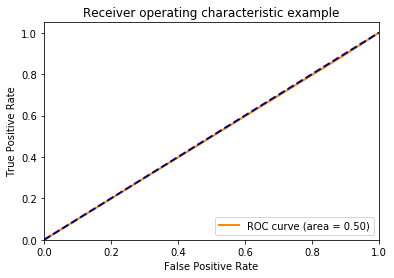

In [237]:
# LOGISTIC REGRESSION
model = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

acc_score = metrics.accuracy_score(y_test, y_predict)
print('ACC Score:', acc_score)

c_matrix = metrics.confusion_matrix(y_test, y_predict)
print('Confusion Matrix:\n',c_matrix)

f1_score = metrics.f1_score(y_test, y_predict)
print('F1-score:\n',f1_score)

precision = metrics.precision_score(y_test, y_predict)
print('Precision:\n',precision)

recall = metrics.recall_score(y_test, y_predict)
print('Recall:\n',recall)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict) 
roc_auc = metrics.auc(fpr, tpr)

auc = metrics.auc(fpr, tpr)
print('AUC:', auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ACC Score: 0.5216346153846154
Confusion Matrix:
 [[  0 199]
 [  0 217]]
F1-score:
 0.6856240126382307
Precision:
 0.5216346153846154
Recall:
 1.0
AUC: 0.5


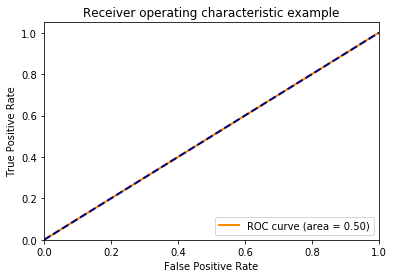

In [241]:
# SVC

model = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42))
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

acc_score = metrics.accuracy_score(y_test, y_predict)
print('ACC Score:', acc_score)

c_matrix = metrics.confusion_matrix(y_test, y_predict)
print('Confusion Matrix:\n',c_matrix)

f1_score = metrics.f1_score(y_test, y_predict)
print('F1-score:\n',f1_score)

precision = metrics.precision_score(y_test, y_predict)
print('Precision:\n',precision)

recall = metrics.recall_score(y_test, y_predict)
print('Recall:\n',recall)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)
roc_auc = metrics.auc(fpr, tpr)

auc = metrics.auc(fpr, tpr)
print('AUC:', auc)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ACC Score: 0.4831730769230769
Confusion Matrix:
 [[ 40 159]
 [ 56 161]]
F1-score:
 0.5996275605214153
Precision:
 0.503125
Recall:
 0.7419354838709677
AUC: 0.47147025449829794


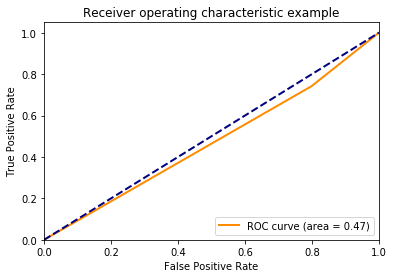

In [239]:
# GAUSSIAN
model = GaussianNB()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

acc_score = metrics.accuracy_score(y_test, y_predict)
print('ACC Score:', acc_score)

c_matrix = metrics.confusion_matrix(y_test, y_predict)
print('Confusion Matrix:\n',c_matrix)

f1_score = metrics.f1_score(y_test, y_predict)
print('F1-score:\n',f1_score)

precision = metrics.precision_score(y_test, y_predict)
print('Precision:\n',precision)

recall = metrics.recall_score(y_test, y_predict)
print('Recall:\n',recall)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict) 
roc_auc = metrics.auc(fpr, tpr)

auc = metrics.auc(fpr, tpr)
print('AUC:', auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ACC Score: 0.5168269230769231
Confusion Matrix:
 [[ 32 167]
 [ 34 183]]
F1-score:
 0.6455026455026456
Precision:
 0.5228571428571429
Recall:
 0.8433179723502304
AUC: 0.5020609962253665


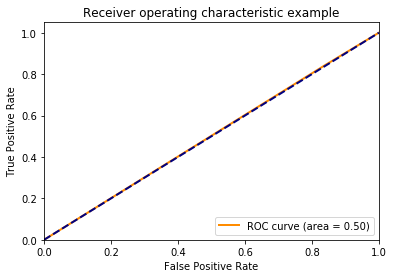

In [240]:
# MPL
# Initialize our classifier
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

acc_score = metrics.accuracy_score(y_test, y_predict)
print('ACC Score:', acc_score)

c_matrix = metrics.confusion_matrix(y_test, y_predict)
print('Confusion Matrix:\n',c_matrix)

f1_score = metrics.f1_score(y_test, y_predict)
print('F1-score:\n',f1_score)

precision = metrics.precision_score(y_test, y_predict)
print('Precision:\n',precision)

recall = metrics.recall_score(y_test, y_predict)
print('Recall:\n',recall)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict) 
roc_auc = metrics.auc(fpr, tpr)

auc = metrics.auc(fpr, tpr)
print('AUC:', auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## FUND FACTSHEET

In [333]:
df = pd.read_csv('alg_input.csv')
cols = [0,1]
df.drop(df.columns[cols],axis=1,inplace=True)
df.drop([0], inplace = True)
df.pct_change(axis='columns')


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZION,ZTS,sp500
1,NaN,-0.021171,2.157799,-0.298442,-0.379910,0.290572,-0.685258,0.816744,1.036098,-0.224947,...,-0.753893,0.486557,1.221879,-0.539508,-0.322352,0.173810,0.457492,-0.479003,0.092077,-0.967320
2,NaN,-0.019086,2.183822,-0.296661,-0.373509,0.282942,-0.683809,0.805467,1.007570,-0.218200,...,-0.759923,0.525283,1.200000,-0.537325,-0.312867,0.181845,0.415052,-0.472315,0.076325,-0.967170
3,NaN,-0.015660,2.193253,-0.292547,-0.380232,0.303511,-0.698381,0.878385,0.982802,-0.212883,...,-0.757593,0.521436,1.198995,-0.539485,-0.317935,0.178980,0.439743,-0.474602,0.073759,-1.000000
4,NaN,-0.025798,2.198852,-0.293394,-0.384985,0.327389,-0.704709,0.894636,1.006320,-0.212927,...,-0.767150,0.517976,1.237500,-0.541605,-0.332365,0.211197,0.419376,-0.471133,0.071504,-0.967127
5,NaN,-0.025377,2.163740,-0.291813,-0.381807,0.330412,-0.700070,0.852804,1.003783,-0.205160,...,-0.763466,0.511221,1.216641,-0.538030,-0.335759,0.218445,0.418303,-0.471803,0.066831,-0.967029
6,NaN,-0.026775,2.151112,-0.288114,-0.385065,0.327896,-0.705472,0.876777,1.014899,-0.194135,...,-0.761005,0.522156,1.201173,-0.537110,-0.322417,0.208988,0.399081,-0.471096,0.073866,-0.967245
7,NaN,-0.022543,2.086150,-0.264034,-0.395921,0.340989,-0.702624,0.838365,1.023749,-0.185393,...,-0.763602,0.539348,1.168128,-0.535320,-0.320259,0.203780,0.420840,-0.479539,0.077193,-0.967427
8,NaN,-0.025733,2.042965,-0.263940,-0.393455,0.344183,-0.701293,0.827269,1.006050,-0.185222,...,-0.764824,0.529508,1.166345,-0.532555,-0.319484,0.187026,0.449495,-0.485290,0.070601,-1.000000
9,NaN,-0.022676,2.071572,-0.257881,-0.404750,0.356284,-0.700191,0.802458,1.030808,-0.186148,...,-0.766570,0.532875,1.161118,-0.532833,-0.314921,0.133872,0.500804,-0.481457,0.074126,-0.967448
10,NaN,-0.013985,2.091882,-0.271736,-0.399194,0.346954,-0.688439,0.754825,1.035741,-0.207612,...,-0.761790,0.526658,1.140758,-0.529593,-0.311846,0.146182,0.490046,-0.485594,0.073802,-0.967427


In [349]:
df = pd.read_csv('sp500.csv')
df.columns = ['Date', 'index']
df
prices = df['index']
daily_return = prices.pct_change(1) # 1 for ONE DAY lookback
monthly_return = prices.pct_change(21) # 21 for ONE MONTH lookback
annual_return = prices.pct_change(252) # 252 for ONE YEAR lookback

annual_return = annual_return.dropna()
monthly_return = monthly_return.dropna()
daily_return = daily_return.dropna()

df_returns = pd.DataFrame()
df_returns['Date'] = df['Date']
df_returns['index'] = pd.DataFrame(daily_return)

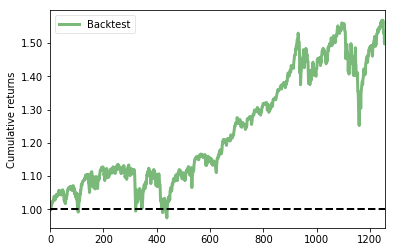

In [350]:
pf.plot_rolling_returns(daily_return)
# pf.create_returns_tear_sheet(daily_return)

Start date,2014-05-16
End date,2019-05-16
Total months,59
,Backtest
Annual return,8.9%
Cumulative returns,53.2%
Annual volatility,13.3%
Sharpe ratio,0.71
Calmar ratio,0.45
Stability,0.87
Max drawdown,-19.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.78,2018-09-20,2018-12-24,2019-04-23,154
1,14.16,2015-05-21,2016-02-11,2016-07-11,298
2,10.16,2018-01-26,2018-02-08,2018-08-24,151
3,7.40,2014-09-18,2014-10-15,2014-10-31,32
4,4.95,2014-12-05,2014-12-16,2014-12-22,12


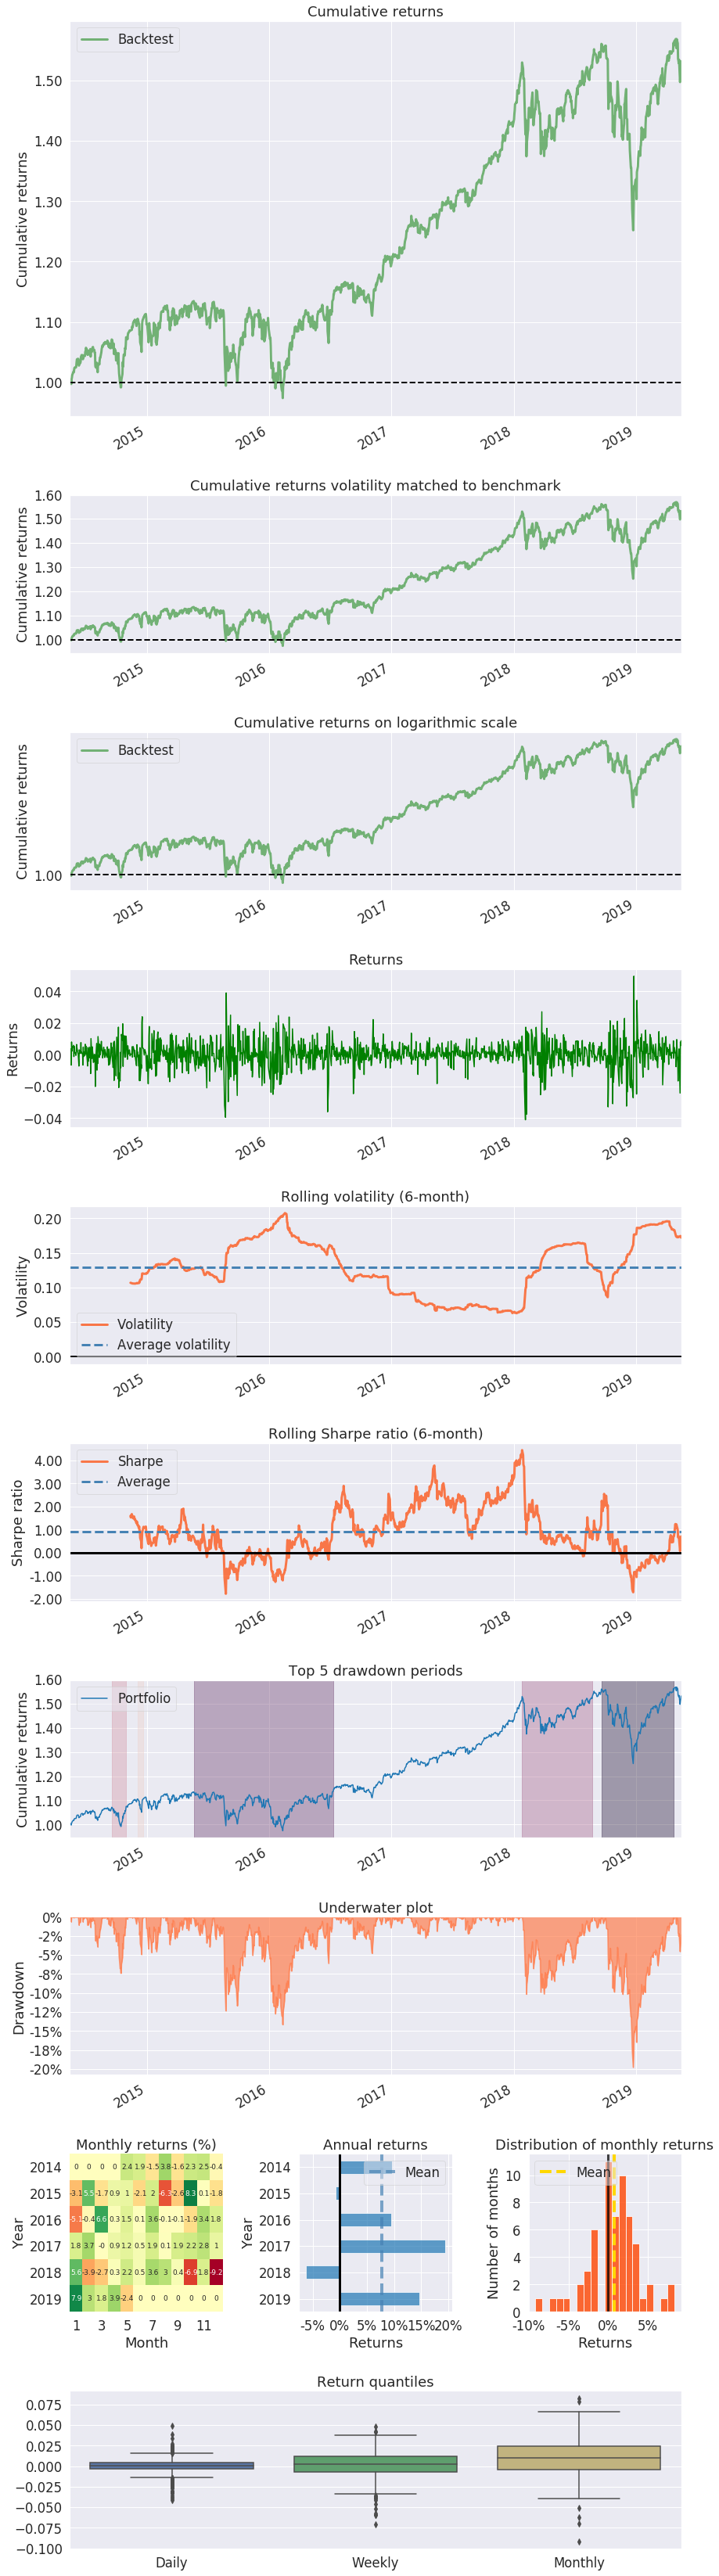

In [351]:
returns = df_returns['index']
returns.index = pd.to_datetime(df_returns['Date'])
pf.create_returns_tear_sheet(returns)

Stats for index from 2014-05-16 00:00:00 - 2019-05-16 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
-               -         18.30%  -294.83%

Annualized Returns:
mtd      3m       6m       ytd    1y       3y      5y      10y     incep.
-------  -------  -------  -----  -------  ------  ------  ------  --------
834.95%  -18.23%  300.09%  4.74%  119.07%  -3.17%  18.30%  18.30%  18.30%

Periodic:
        daily       monthly      yearly
------  ----------  -----------  --------
sharpe  -           -0.45        -0.53
mean    inf%        -31571.31%   -61.36%
vol     -           70746.58%    115.76%
skew    -           -7.72        -2.01
kurt    -           59.78        4.09
best    inf%        5272.43%     11.78%
worst   -55622.72%  -158049.66%  -263.85%

Drawdowns:
max       avg         # days
--------  --------  --------
-294.83%  -230.08%       201

Misc:
---------------  --------

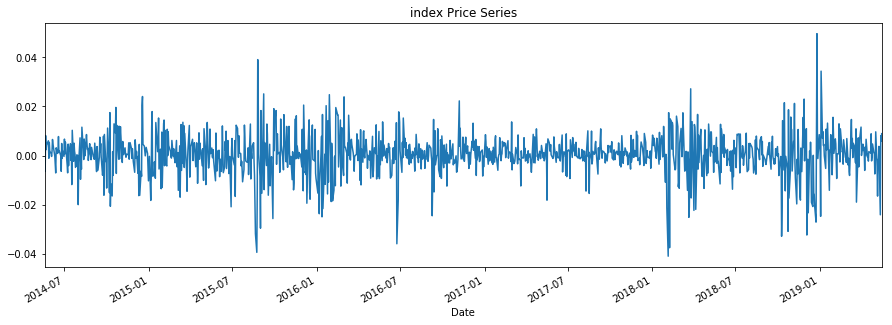

In [337]:
perf = df_returns['index'].calc_stats()
perf.plot()


perf.display()

In [338]:
perf.display_monthly_returns()

  Year      Jan       Feb      Mar      Apr     May       Jun      Jul      Aug      Sep         Oct      Nov      Dec      YTD
------  -------  --------  -------  -------  ------  --------  -------  -------  -------  ----------  -------  -------  -------
  2014     0         0        0        0     -52.05   -120.19  5272.43  -116.6   -183.9      -521.09  -121.67   305.55  -368.18
  2015    26       -77.25   197.53    15.16  -37.62   -142.07  -185.44   269.43  -327.32     -125.21    -3.51   102.8     -8.72
  2016  -363.07   -132.8    -74.88   148.22  -80.15  -1449.4    -87.97  -245.64  -435.37     -101.53  2070       74.76   -50.73
  2017   -80.81    189.74   -12.54   -15.16  -75.96   -433.33  -147.49  -885.69   -35.24      -74.51   767.26  -163.28    11.78
  2018  -109.43  -2369.15  -224.1   -159.46  -15.97   -111.02   544.08   -97.25  -105.11  -158050      -24.7      3.94  -263.85
  2019     1.24   -132.86  -338.34   -85.87  834.95      0        0        0        0           0       

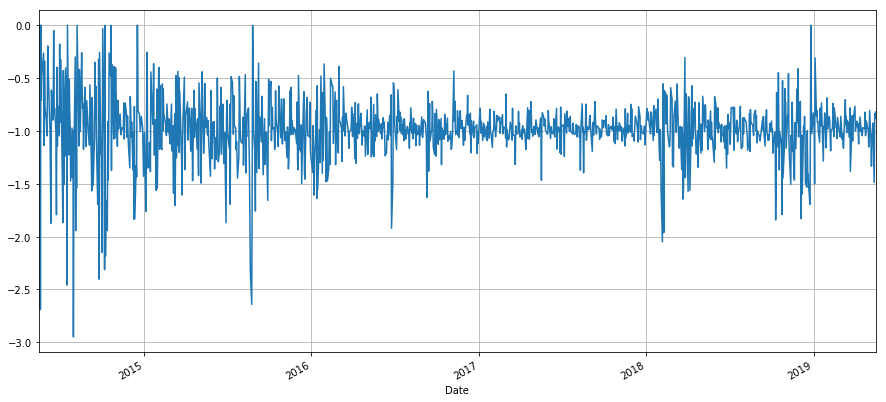

In [339]:
ffn.to_drawdown_series(df_returns['index']).plot(figsize=(15,7),grid=True)


In [340]:
perf.stats

start                    2014-05-16 00:00:00
end                      2019-05-16 00:00:00
rf                                         0
total_return                             NaN
cagr                                0.183007
max_drawdown                        -2.94831
calmar                              0.062072
mtd                                  8.34951
three_month                        -0.182325
six_month                            3.00093
ytd                                0.0474305
one_year                             1.19065
three_year                        -0.0316823
five_year                           0.183007
ten_year                            0.183007
incep                               0.183007
daily_sharpe                             NaN
daily_sortino                            inf
daily_mean                               inf
daily_vol                                NaN
daily_skew                               NaN
daily_kurt                               NaN
best_day  

In [341]:
perf.display_lookback_returns()

mtd      834.95%
3m       -18.23%
6m       300.09%
ytd        4.74%
1y       119.07%
3y        -3.17%
5y        18.30%
10y       18.30%
incep     18.30%
Name: index, dtype: object

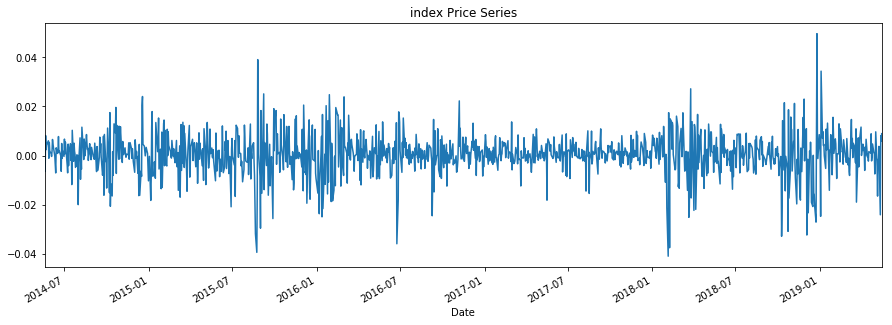

In [353]:
perf.plot()